In [1]:
from src.tensor import Tensor
import src.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from mnist import MNIST
np.set_printoptions(suppress=True)

In [2]:
mndata = MNIST('./mnist_dataset/')
mndata.gz = True
mnist_x_train, mnist_y_train = mndata.load_training()
mnist_x_test, mnist_y_test = mndata.load_testing()
x_train = Tensor(list(mnist_x_train))
x_test = Tensor(list(mnist_x_test))
y_train = Tensor(list(mnist_y_train))
y_test = Tensor(list(mnist_y_test))

In [3]:
rng = np.random.default_rng(seed=1)

# Scale down pixels from 0-255 to 0-1
x_train = x_train / 255
x_test = x_test / 255

# OneHot label vectors
def onehot(vector):
    tmp = []
    for scalar in vector.data:
        tmp2 = [1 if i==scalar else 0 for i in range(10)]
        tmp.append(tmp2)
    return Tensor(tmp)
y_train = onehot(y_train)
y_test = onehot(y_test)

print(f'x_train={x_train.shape}, y_train={y_train.shape}')
print(f'x_test={x_test.shape}, y_test={y_test.shape}')

x_train=(60000, 784), y_train=(60000, 10)
x_test=(10000, 784), y_test=(10000, 10)


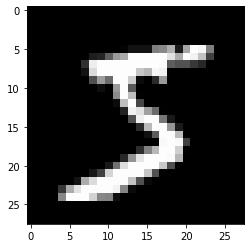

In [4]:
# Visualize X
img = np.array(x_train[0].tolist())
plt.imshow(img.reshape(28, 28),cmap='gray')
plt.show()

In [5]:
# Multinomial sampling with replacement
def draw_batch(batch_size): 
    draw = lambda: int(rng.random() * x_train.shape[0])
    batch = [draw() for _ in range(batch_size)]
    return x_train[batch], y_train[batch]

mlp = nn.Sequential((
    nn.Linear(784, 512),
    nn.Tanh(),
    nn.Linear(512, 256),
    nn.Tanh(),
    nn.Linear(256, 10, bias=False),
    nn.Softmax()
))
mlp[0].W = mlp[0].W * 0.11
mlp[2].W = mlp[2].W * 0.07
losses = []

std=1.0557970447686302
std=0.99887900769033
std=8.757189614755358
Epoch 0: 11.825661744020504
Epoch 1: 69.02863195929254
Epoch 2: 44.842035493133
Epoch 3: 43.89040681271691
Epoch 4: 41.460859452852944
Epoch 5: 23.24562754754748
Epoch 6: 18.61632087876084
Epoch 7: 22.823035516690524
Epoch 8: 15.236382582398825
Epoch 9: 12.587921039869483
Epoch 10: 9.928426330698734
Epoch 11: 6.198611605558828
Epoch 12: 8.182509879814077
Epoch 13: 4.638420363704012
Epoch 14: 4.578673193269197
Epoch 15: 4.308791951084954
Epoch 16: 2.2772816936949587
Epoch 17: 1.5859587530209744
Epoch 18: 1.4503197573068416
Epoch 19: 1.3179815454177448
Epoch 20: 1.4064521053032557
Epoch 21: 1.60247184362052
Epoch 22: 2.9161386813239085
Epoch 23: 1.9841995384307192
Epoch 24: 2.7756733912961056
Epoch 25: 3.210977343602159
Epoch 26: 2.759500526811972
Epoch 27: 2.4326949593603624
Epoch 28: 4.2957735614102415
Epoch 29: 3.3774165687667863
Epoch 30: 3.256971350684462
Epoch 31: 1.608298294194769
Epoch 32: 1.8479904105274056
Epoch 

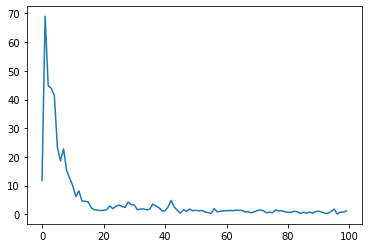

In [6]:
epochs = 100
batch_size = 32
lr = 0.1
breakpoint = -1
for e in range(epochs):
    x, y = draw_batch(batch_size)
    out = mlp(x, breakpoint=breakpoint, printstddev=(e==0))

    loss = nn.nlll(out, y, reduction='mean')
    loss.backward()
    mlp.optimize(lr=lr)
    mlp.zero_grad()

    losses.append(loss.data.item())
    print(f'Epoch {e}: {loss.data.item()}')

plt.plot(losses)
plt.show()

In [8]:
correct = 0
for i in range(len(x_test)):
    y = y_test[i]
    x = mlp(x_test[i])
    corr = np.argmax(y.data)
    predicted = np.argmax(x.data)
    if predicted == corr: correct += 1

print(f'Test accuracy: {(correct/len(x_test.data))*100}%')

Test accuracy: 82.22%
